In [ ]:
import json
import pandas as pd
import os
import shutil
from glob import glob
import zipfile
import numpy as np
from tqdm import tqdm
from shapely import wkb
from shapely.geometry import shape
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
QV_THRESHOLD = 20 

In [ ]:
class_list = {
    0: "Tumor epithelial",
    1: "Non-tumor epithelial",
    2: "Basal/Myoepithelial",
    3: "Smooth muscle",
    4: "Fibroblast",
    5: "Endothelial",
    6: "T cell",
    7: "B cell",
    8: "Plasma cell",
    9: "Myeloid",
    10: "Adipocyte",
    11: "Other/Unknown"
}
marker_genes = {
    'Tumor epithelial': [
        b'EPCAM', b'KRT14', b'KRT5', b'KRT23', b'ERBB2', b'MKI67', b'GATA3'
    ],
    'Non-tumor epithelial': [
        b'EPCAM', b'KRT8', b'KRT18', b'KRT19', b'CDH1'
    ],
    'Basal/Myoepithelial': [
        b'KRT5', b'KRT14', b'ACTA2', b'MYL9'
    ],
    'Smooth muscle': [
        b'ACTA2', b'MYH11', b'TAGLN', b'MYLK', b'MYL9'
    ],
    'Fibroblast': [
        b'PDGFRA', b'PDGFRB', b'DPT', b'LUM', b'SFRP1', b'FBLN1', b'SFRP4'
    ],
    'Endothelial': [
        b'PECAM1', b'KDR', b'CD93', b'EGFL7', b'VWF', b'CLEC14A'
    ],
    'T cell': [
        b'CD3D', b'CD3E', b'CD3G', b'NKG7', b'GZMA', b'CCL5', b'TRAC', b'TCF7', b'LTB', b'IL2RG'
    ],
    'B cell': [
        b'CD79A', b'CD79B', b'MS4A1', b'MZB1', b'CD19', b'PAX5'
    ],
    'Plasma cell': [
        b'MZB1', b'PRDM1', b'TNFRSF17'
    ],
    'Myeloid': [
        b'CD68', b'CD14', b'CD163', b'MRC1', b'C1QA', b'AIF1',
        b'S100A8', b'CD86', b'ITGAX', b'TPSAB1', b'CPA3', b'KIT'
    ],
    'Adipocyte': [
        b'ADIPOQ', b'LPL', b'PPARG'
    ],
    'Other/Unknown': []
}
class_colors_hex = {
    "Tumor epithelial": "#FF0000",
    "Non-tumor epithelial": "#FFB6C1",
    "Basal/Myoepithelial": "#FFA500",
    "Smooth muscle": "#8B4513",
    "Fibroblast": "#00FF00",
    "Endothelial": "#0000FF",
    "T cell": "#FFFF00",
    "B cell": "#FF00FF",
    "Plasma cell": "#9400D3",
    "Myeloid": "#00FFFF",
    "Adipocyte": "#FFC0CB",
    "Other/Unknown": "#808080"
}
class_colors = {
    "Tumor epithelial": [255, 0, 0],        # 빨강 - 종양
    "Non-tumor epithelial": [255, 182, 193],  # 연한 분홍 - 정상 상피
    "Basal/Myoepithelial": [255, 165, 0],   # 주황 - 기저/근상피
    "Smooth muscle": [139, 69, 19],          # 갈색 - 평활근
    "Fibroblast": [0, 255, 0],               # 초록 - 섬유아세포
    "Endothelial": [0, 0, 255],              # 파랑 - 혈관내피
    "T cell": [255, 255, 0],                 # 노랑 - T세포
    "B cell": [255, 0, 255],                 # 마젠타 - B세포
    "Plasma cell": [148, 0, 211],            # 보라 - 형질세포
    "Myeloid": [0, 255, 255],                # 시안 - 골수계
    "Adipocyte": [255, 192, 203],            # 분홍 - 지방세포
    "Other/Unknown": [128, 128, 128]         # 회색 - 기타/미분류
}


In [ ]:
xenium_annotation_list=glob('../../data/Brest_spatialTranscriptome/xenium_seg/*_xenium_nucleus_seg.parquet')
xenium_wsi_list = [f.replace("xenium_seg/", "wsis/") for f in xenium_annotation_list]
xenium_wsi_list = [f.replace("_xenium_nucleus_seg.parquet", ".tif") for f in xenium_wsi_list]
xenium_metadata_list = [f.replace("wsis/", "metadata/") for f in xenium_wsi_list]
xenium_metadata_list = [f.replace(".tif", ".json") for f in xenium_metadata_list]
save_path='../../data/Brest_spatialTranscriptome/preprocessed_xenium/'
for i in tqdm(range(len(xenium_annotation_list))):
    zip_path = xenium_annotation_list[i]
    wsi_path = xenium_wsi_list[i]
    create_dir(save_path+'wsis/')
    create_dir(save_path+'metadata/')
    shutil.copy(wsi_path, f'{save_path}wsis/{os.path.basename(wsi_path)}')
    shutil.copy(xenium_metadata_list[i], f'{save_path}metadata/{os.path.basename(xenium_metadata_list[i])}')


In [ ]:

def classify_cell_by_genes(gene_list, marker_dict):
    """여러 유전자를 기반으로 cell type scoring"""
    scores = {cell_type: 0 for cell_type in marker_dict.keys()}
    
    for gene in gene_list:
        for cell_type, markers in marker_dict.items():
            if gene in markers:
                scores[cell_type] += 1
    
    # 가장 높은 점수의 cell type 반환
    max_score = max(scores.values())
    if max_score == 0:
        return 'Other/Unknown', 0
    
    best_type = max(scores, key=scores.get)
    return best_type, scores
save_path='../../data/Brest_spatialTranscriptome/preprocessed_xenium/'
xenium_transcripts_list=[f.replace("xenium_seg/", "transcripts/") for f in xenium_annotation_list]
xenium_transcripts_list=[f.replace("_xenium_nucleus_seg.parquet", "_transcripts.parquet") for f in xenium_transcripts_list]
for i in range(len(xenium_transcripts_list)):
    xenium_transcript_path = xenium_transcripts_list[i]
    df_transcript = pd.read_parquet(xenium_transcript_path)
    df_filtered = df_transcript[df_transcript['qv'] > QV_THRESHOLD].copy()
    
    df_filtered = df_filtered[~df_filtered['feature_name'].str.decode('utf-8').str.contains('BLANK|NegControl|antisense', case=False, na=False)]
    xenium_annotation_path=xenium_annotation_list[i]
    df_seg = pd.read_parquet(xenium_annotation_path)
    df=pd.DataFrame(columns=['x1','y1','x2','y2','class_name'])
    annotations = []
    grouped_transcripts = df_filtered.groupby('cell_id')['feature_name'].apply(list).to_dict()
    for j in tqdm(range(len(df_seg))):
        temp_df_seg=df_seg.iloc[j]
        cell_id=temp_df_seg.name
        geom_binary=temp_df_seg['geometry']
        polygon = wkb.loads(geom_binary)
        x,y=polygon.exterior.xy
        x1=int(np.min(x))
        y1=int(np.min(y))
        x2=int(np.max(x))
        y2=int(np.max(y))
        try:
            genes_in_cell=grouped_transcripts[cell_id]
            cell_type, score = classify_cell_by_genes(genes_in_cell, marker_genes)
            annotations.append({
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'class_name': cell_type,
            })
        except KeyError:
            continue
    df = pd.DataFrame(annotations)
    create_dir(save_path+'labels/')    
    df.to_csv(save_path+'labels/'+os.path.basename(xenium_annotation_path).replace('_xenium_nucleus_seg.parquet', '.csv'), index=False)

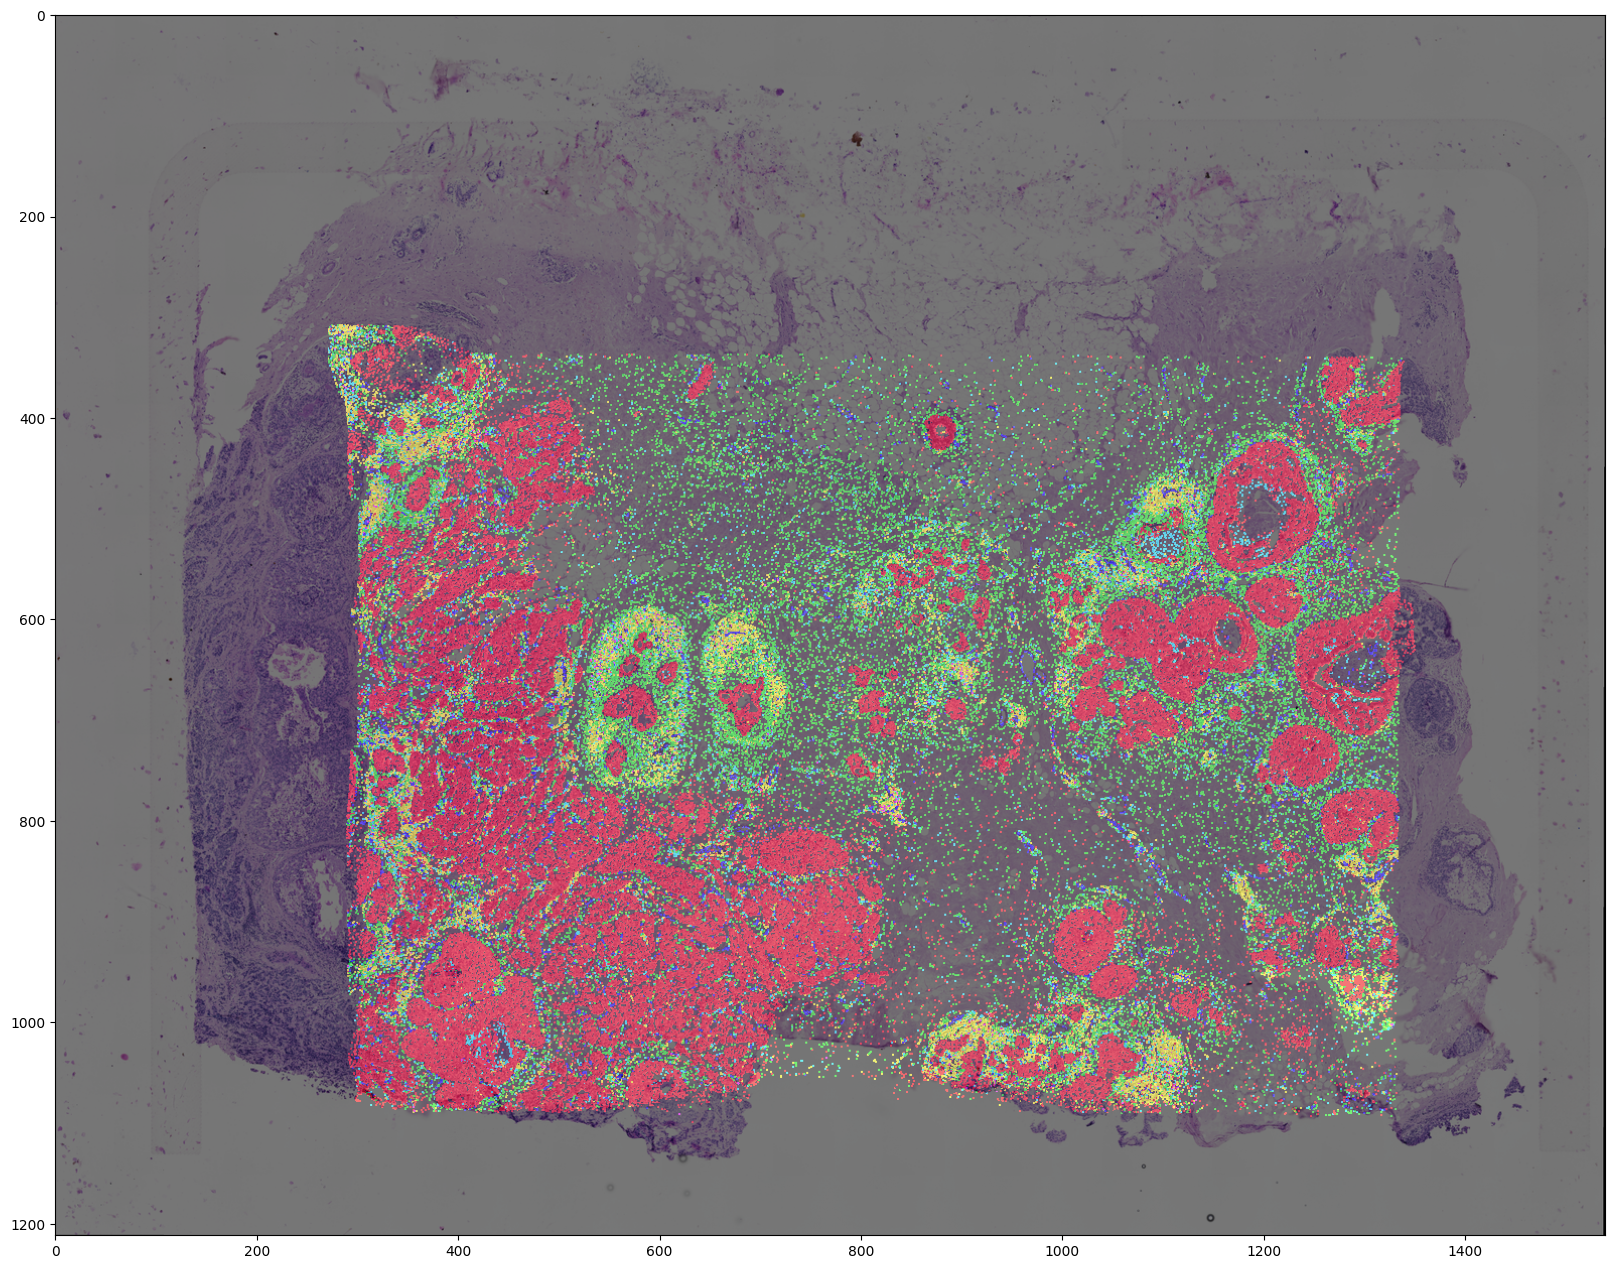

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import openslide as ops

reduction_factor=20
slide=ops.OpenSlide('../../data/Brest_spatialTranscriptome/preprocessed_xenium/wsis/NCBI785.tif')
thumbnail = slide.get_thumbnail((slide.level_dimensions[0][0] // reduction_factor, slide.level_dimensions[0][1] // reduction_factor))
mask=np.ones_like(np.array(thumbnail)) * 0
labels_df=pd.read_csv('../../data/Brest_spatialTranscriptome/preprocessed_xenium/labels/NCBI785.csv')

fig, ax = plt.subplots(figsize=(22, 20))

for idx, row in labels_df.iterrows():
    x=row['x1']/reduction_factor + row['x2']/reduction_factor
    x=x//2
    y=row['y1']/reduction_factor + row['y2']/reduction_factor
    y=y//2
    mask[int(y):int(y)+2, int(x):int(x)+2]=np.array(class_colors[row['class_name']])/255.

ax.imshow(mask*0.5 + np.array(thumbnail)/255.*0.5)
ax.axis('off')
ax.set_title('Cell Type Annotation', fontsize=16, fontweight='bold')

# 범례 추가
legend_patches = []
for class_name, hex_color in class_colors_hex.items():
    patch = mpatches.Patch(color=hex_color, label=class_name)
    legend_patches.append(patch)

ax.legend(handles=legend_patches, 
         loc='upper right', 
         fontsize=10,
         framealpha=0.9,
         bbox_to_anchor=(1.15, 1.0))

plt.tight_layout()
plt.show()

In [ ]:
df_filtered[df_filtered['cell_id']==b'aaaeppaj-1']

In [ ]:
grouped_transcripts